##### Copyright 2018 Lucid Authors

Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Decomposed Feature Visualization (rough)

Decomposed feature visualization is a techhnique for understanding the *mechanics* of how neural network features operate. This is a very early experiment with them.




# Setup

In [0]:
# Install Lucid

#!pip install --quiet lucid==0.0.5
!pip install -U --no-deps  git+https://github.com/tensorflow/lucid.git
!npm install -g svelte-cli@2.2.0

In [0]:
# Imports

import numpy as np
import scipy.ndimage as nd
import tensorflow as tf

import lucid.modelzoo.vision_models as models
from lucid.misc.io import show, load
import lucid.optvis.objectives as objectives
import lucid.optvis.param as param
import lucid.optvis.render as render
import lucid.optvis.transform as transform

from lucid.misc.gradient_override import gradient_override_map
from lucid.misc.io.showing import _image_url
import lucid.scratch.web.svelte as lucid_svelte
from lucid.misc.channel_reducer import ChannelReducer

In [0]:
# Let's import a model from the Lucid modelzoo!

model = models.InceptionV1()
model.load_graphdef()

In [0]:
obj = objectives.neuron("mixed4e_pre_relu", 55)

In [0]:
with tf.Graph().as_default(), tf.Session() as sess:
    t_input = tf.placeholder("float32", [1, None, None, 3])
    T = render.import_model(model, t_input, t_input)
    loss = obj(T)
    t_layer = T("mixed4d")
    vecs = 0.001*np.random.randn(1, 3, 3, t_layer.shape[-1])
    t_layer_grad = tf.gradients(loss, t_layer)[0]
    W = t_layer_grad.eval({t_layer: vecs})

In [0]:
[m_layer] = [layer for layer in model.layers if layer.name == "mixed4d"]
prev_acts = m_layer.activations
prev_attrs = prev_acts * W[None, :]

128 230036.47



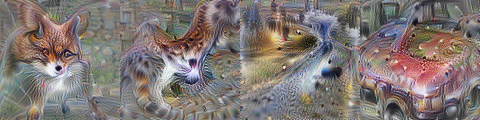

512 277046.38



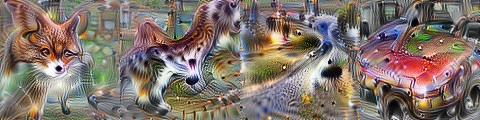

1024 279407.88



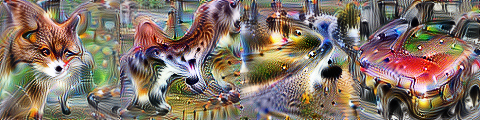

2048 315404.53



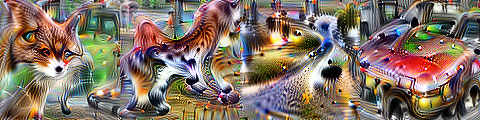

In [31]:
prev_attrs_ = np.concatenate([np.maximum(prev_attrs, 0), np.maximum(-prev_attrs, 0)], axis=1)[:10000]

nmf = ChannelReducer(4, "NMF")
spatial_factors = nmf.fit_transform(prev_attrs_).astype("float32")
channel_factors = nmf._reducer.components_.astype("float32")

param_f = lambda: param.image(120, batch=4)
obj = sum(objectives.direction_neuron("mixed4d", channel_factors[i][:528] - channel_factors[i][528:], batch=i)
          + 0.5*objectives.direction("mixed4d", channel_factors[i][:528] - channel_factors[i][528:], batch=i)
          for i in range(4))
group_icons = render.render_vis(model, obj, param_f, verbose=True, thresholds=(128, 512, 1024, 2048))[-1]

In [0]:
prev_attrs__ = prev_attrs[prev_attrs.sum(1) > 100]
prev_attrs__ /= np.sqrt(1e-1 + (prev_attrs__**2).sum(1))[:, None]

Clustering Done! :) 

128 23777.04



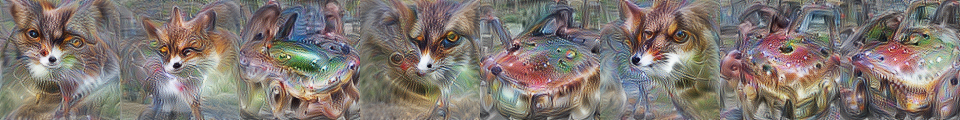

512 29111.822



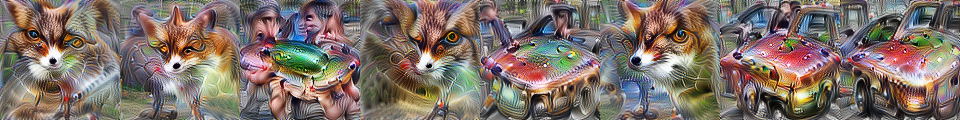

1024 28238.006



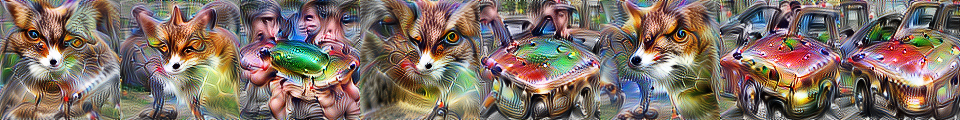


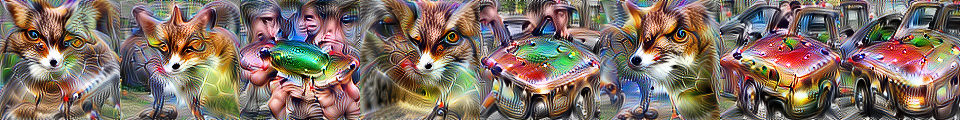

In [0]:
from sklearn.cluster import KMeans

kmeans = KMeans(8)
clusters = kmeans.fit_transform(prev_attrs__).astype("float32")
channel_factors = kmeans.cluster_centers_

print "Clustering Done! :) "
print ""

param_f = lambda: param.image(120, batch=8)
obj = sum(objectives.direction_neuron("mixed4d", channel_factors[i][:528], batch=i)
          + 0.25*objectives.direction("mixed4d", channel_factors[i][:528], batch=i)
          for i in range(8))
group_icons = render.render_vis(model, obj, param_f, verbose=True, thresholds=(128, 512, 1024, 2048))[-1]

# Neuron specific Caricatures

In [0]:
def imgToModelSize(arr):
  W = model.image_shape[0]
  w, h, _ = arr.shape
  s = float(W) / min(w,h)
  arr = nd.zoom(arr, [s, s, 1], mode="nearest")
  w, h, _ = arr.shape
  dw, dh = (w-W)//2, (h-W)//3
  return arr[dw:dw+W, dh:dh+W]

In [0]:
@objectives.wrap_objective
def weighted_dot_compare(layer, batch=1, W=1):
  def inner(T):
    dot = tf.reduce_sum(T(layer)[batch] * T(layer)[0] * W)
    return dot
  return inner

In [0]:
def caricature(img, W):
  layer="mixed4d"
  n_steps=512
  cossim_pow=0.0


  with tf.Graph().as_default(), tf.Session() as sess:
    img = imgToModelSize(img)

    objective = objectives.Objective.sum([
        1.0 * weighted_dot_compare(layer, W=W),
        objectives.blur_input_each_step(),
    ])

    t_input = tf.placeholder(tf.float32, img.shape)
    param_f = param.image(img.shape[0], decorrelate=True, fft=True, alpha=False)
    param_f = tf.stack([param_f[0], t_input])

    transforms = [
      transform.pad(8, mode='constant', constant_value=.5),
      transform.jitter(8),
      transform.random_scale([0.9, 0.95, 1.05, 1.1] + [1]*4),
      transform.random_rotate(range(-5, 5) + [0]*5),
      transform.jitter(2),
    ]

    T = render.make_vis_T(model, objective, param_f, transforms=transforms)
    loss, vis_op, t_image = T("loss"), T("vis_op"), T("input")

    tf.global_variables_initializer().run()
    for i in range(n_steps): _ = sess.run([vis_op], {t_input: img})

    result = t_image.eval(feed_dict={t_input: img})
    show(result[0])


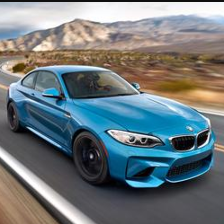


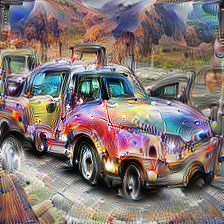


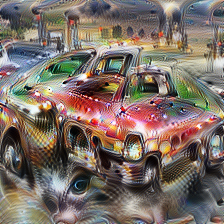

In [79]:
img = load("https://storage.googleapis.com/lucid-static/building-blocks/examples/car2.png")[::2,::2,:3]

show(img)
caricature(img, W=1)
caricature(img, W=W[None, None, :])


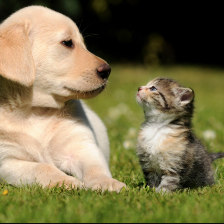


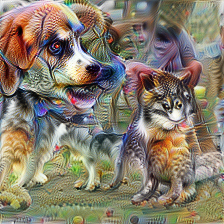


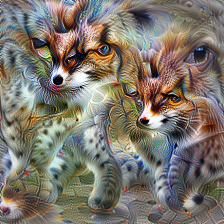

In [80]:
img = load("https://storage.googleapis.com/lucid-static/building-blocks/examples/dog_cat.png")

show(img)
caricature(img, W=1)
caricature(img, W=W[None, None, :])